In [1]:
import cmasher as cmr
import numpy as np
from astropy.io.votable import from_table, parse_single_table, writeto
from astropy.wcs.utils import proj_plane_pixel_scales
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from mpl_toolkits.axes_grid1 import make_axes_locatable
from astropy.coordinates import SkyCoord, FK4
from astropy.io import fits, votable
from astropy.visualization import simple_norm
from astropy.wcs import WCS
import astropy.units as u
from radio_beam import Beam
from spectral_cube import SpectralCube
import aplpy
import matplotlib.colors as mcolors

## Plot slices of the SMC emission cube with the absorption overlaid

Visualise the locations of absoprtion features against the colun density in their velocity ranges

In [2]:
plt.rc('font', family='serif')

In [3]:
# Define velocity ranges - 11 km/s per slab
vel_start = np.linspace(56, 254, 19)
print (vel_start)

[ 56.  67.  78.  89. 100. 111. 122. 133. 144. 155. 166. 177. 188. 199.
 210. 221. 232. 243. 254.]


In [5]:
# Read in absorption catalogue
#parent_folder = 'sb10944/v3/'
#abs_table = parse_single_table(parent_folder+'askap_absorption.vot').to_table()
abs_table = parse_single_table('gaskap_smc_absorption.vot').to_table()

abs_table

# Read in emission cube
cube = SpectralCube.read('SMC_askap_parkes_wsclean_PBC_K.fits')
vel_cube = cube.with_spectral_unit(u.m/u.s, velocity_convention='radio')
print (vel_cube)

SpectralCube with shape=(220, 3471, 3901) and unit=K:
 n_x:   3901  type_x: RA---SIN  unit_x: deg    range:     0.506808 deg:   31.124026 deg
 n_y:   3471  type_y: DEC--SIN  unit_y: deg    range:   -75.560509 deg:  -68.835494 deg
 n_s:    220  type_s: VRAD      unit_s: m / s  range:    43840.953 m / s:  257847.382 m / s


In [6]:
print (abs_table.colnames)

['id', 'comp_name', 'abs_name', 'ra', 'dec', 'rating', 'flux_peak', 'mean_cont', 'sd_cont', 'opacity_range', 'max_s_max_n', 'max_noise', 'num_chan_noise', 'semi_maj_axis', 'semi_min_axis', 'pa', 'start_vel', 'end_vel', 'length', 'min_optical_depth', 'e_min_optical_depth', 'peak_tau', 'e_peak_tau', 'max_sigma']


In [7]:
power_pat = fits.open('SMC_askap_PB_pattern.fits')
power_wcs = WCS(power_pat[0].header).celestial
power_data = power_pat[0].data
spatial_mask = power_data > 0.6
power_data[~spatial_mask] = np.nan


print("power: {} cube: {}".format(power_data.shape, vel_cube.shape))
#    pix_pos = power_wcs.wcs_world2pix(spectra_table['ra'], spectra_table['dec'], 0)
#    power_vals = power_pat[0].data[0, 0, pix_pos[1].astype(int), pix_pos[0].astype(int)]
#    return power_vals



power: (3471, 3901) cube: (220, 3471, 3901)


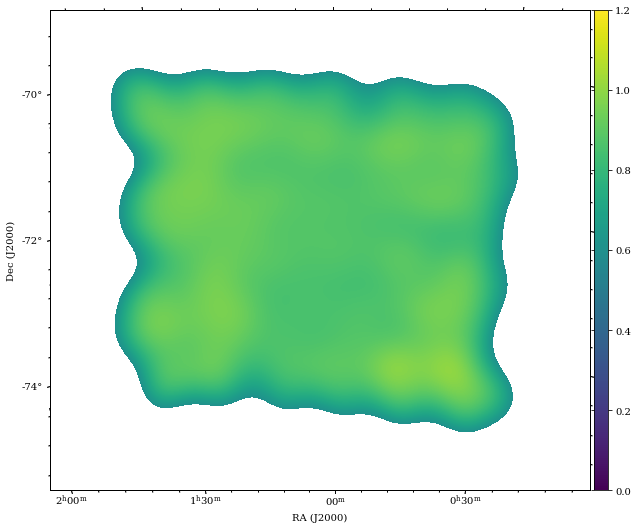

In [8]:
power_data[~spatial_mask] = np.nan

gc = aplpy.FITSFigure(power_pat)
gc.show_colorscale(vmin=0, vmax=1.2)
#gc.image.set_alpha(0.7)
gc.add_colorbar()

(1, 3471, 3901)
INFO: Setting slices=[0] [aplpy.core]
INFO: Auto-setting vmin to -5.040e+02 [aplpy.core]
INFO: Auto-setting vmax to  5.595e+03 [aplpy.core]


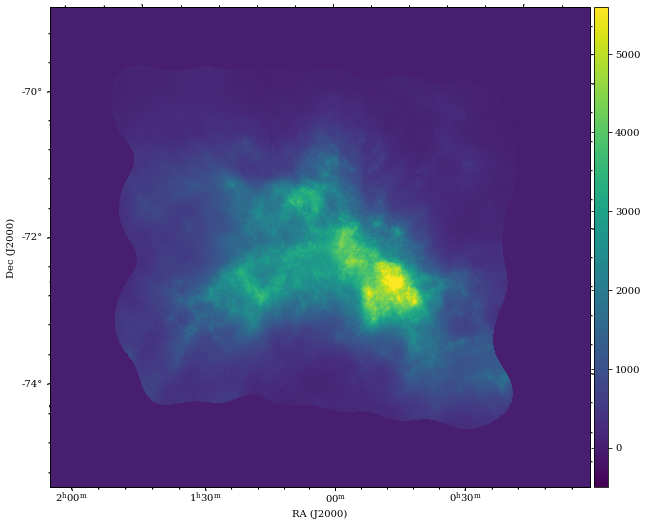

In [9]:
mom0 = fits.open('SMC_askap_parkes_PBC_K_mom0.fits')
mom0_data = mom0[0].data
print(mom0_data.shape)
#spatial_mask = power_data > 0.8
mom0_data[0,~spatial_mask] = 0
gc = aplpy.FITSFigure(mom0[0])
gc.show_colorscale()
gc.add_colorbar()



In [10]:
def extract_slab(vel_cube, vel):
    vel_int = "{:.0f}".format(vel)
    # Extract slab
    print ("extracting slab at vel {}...".format(vel_int))
    slab = vel_cube.spectral_slab(vel*u.km/u.s, (vel+10)*u.km/u.s)
    print (slab.spectral_extrema)
    mom0 = slab.moment0()
    mom0 =  (mom0 * 1.82 * 10**18 /1e3 ) / 1e21
    mom0_fname = 'data/moment0_vel{}.fits'.format(vel_int)
    mom0.write(mom0_fname, overwrite=True)

In [10]:
print (vel_start)
mid_vel = abs_table['start_vel'] + (abs_table['end_vel']-abs_table['start_vel'])/2
for vel in vel_start:
    extract_slab(vel_cube, vel)

[ 56.  67.  78.  89. 100. 111. 122. 133. 144. 155. 166. 177. 188. 199.
 210. 221. 232. 243. 254.]
extracting slab at vel 56...
(<Quantity 55567.33270647 m / s>, <Quantity 66316.51404412 m / s>)


/Users/jamesdempsey/anaconda/envs/python3/lib/python3.6/site-packages/spectral_cube/masks.py:219: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  sliced_data = np.memmap(ntf, mode='w+', shape=data[view].shape,
/Users/jamesdempsey/anaconda/envs/python3/lib/python3.6/site-packages/spectral_cube/masks.py:221: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  sliced_data[:] = data[view]
/Users/jamesdempsey/anaconda/envs/python3/lib/python3.6/site-packages/spectral_cube/masks.py:629: FutureWarning: Using a non-tuple sequence for multidimensional ind

extracting slab at vel 67...
(<Quantity 67293.71234754 m / s>, <Quantity 77065.69538177 m / s>)


/Users/jamesdempsey/anaconda/envs/python3/lib/python3.6/site-packages/spectral_cube/masks.py:219: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  sliced_data = np.memmap(ntf, mode='w+', shape=data[view].shape,
/Users/jamesdempsey/anaconda/envs/python3/lib/python3.6/site-packages/spectral_cube/masks.py:221: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  sliced_data[:] = data[view]
/Users/jamesdempsey/anaconda/envs/python3/lib/python3.6/site-packages/spectral_cube/masks.py:629: FutureWarning: Using a non-tuple sequence for multidimensional ind

extracting slab at vel 78...
(<Quantity 78042.8936852 m / s>, <Quantity 87814.87671943 m / s>)


/Users/jamesdempsey/anaconda/envs/python3/lib/python3.6/site-packages/spectral_cube/masks.py:219: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  sliced_data = np.memmap(ntf, mode='w+', shape=data[view].shape,
/Users/jamesdempsey/anaconda/envs/python3/lib/python3.6/site-packages/spectral_cube/masks.py:221: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  sliced_data[:] = data[view]
/Users/jamesdempsey/anaconda/envs/python3/lib/python3.6/site-packages/spectral_cube/masks.py:629: FutureWarning: Using a non-tuple sequence for multidimensional ind

extracting slab at vel 89...
(<Quantity 88792.07502285 m / s>, <Quantity 98564.05805708 m / s>)


/Users/jamesdempsey/anaconda/envs/python3/lib/python3.6/site-packages/spectral_cube/masks.py:219: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  sliced_data = np.memmap(ntf, mode='w+', shape=data[view].shape,
/Users/jamesdempsey/anaconda/envs/python3/lib/python3.6/site-packages/spectral_cube/masks.py:221: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  sliced_data[:] = data[view]
/Users/jamesdempsey/anaconda/envs/python3/lib/python3.6/site-packages/spectral_cube/masks.py:629: FutureWarning: Using a non-tuple sequence for multidimensional ind

extracting slab at vel 100...
(<Quantity 99541.2563605 m / s>, <Quantity 110290.43769815 m / s>)


/Users/jamesdempsey/anaconda/envs/python3/lib/python3.6/site-packages/spectral_cube/masks.py:219: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  sliced_data = np.memmap(ntf, mode='w+', shape=data[view].shape,
/Users/jamesdempsey/anaconda/envs/python3/lib/python3.6/site-packages/spectral_cube/masks.py:221: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  sliced_data[:] = data[view]
/Users/jamesdempsey/anaconda/envs/python3/lib/python3.6/site-packages/spectral_cube/masks.py:629: FutureWarning: Using a non-tuple sequence for multidimensional ind

extracting slab at vel 111...
(<Quantity 111267.63600158 m / s>, <Quantity 121039.61903581 m / s>)


/Users/jamesdempsey/anaconda/envs/python3/lib/python3.6/site-packages/spectral_cube/masks.py:219: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  sliced_data = np.memmap(ntf, mode='w+', shape=data[view].shape,
/Users/jamesdempsey/anaconda/envs/python3/lib/python3.6/site-packages/spectral_cube/masks.py:221: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  sliced_data[:] = data[view]
/Users/jamesdempsey/anaconda/envs/python3/lib/python3.6/site-packages/spectral_cube/masks.py:629: FutureWarning: Using a non-tuple sequence for multidimensional ind

extracting slab at vel 122...
(<Quantity 122016.81733923 m / s>, <Quantity 131788.80037346 m / s>)


/Users/jamesdempsey/anaconda/envs/python3/lib/python3.6/site-packages/spectral_cube/masks.py:219: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  sliced_data = np.memmap(ntf, mode='w+', shape=data[view].shape,
/Users/jamesdempsey/anaconda/envs/python3/lib/python3.6/site-packages/spectral_cube/masks.py:221: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  sliced_data[:] = data[view]
/Users/jamesdempsey/anaconda/envs/python3/lib/python3.6/site-packages/spectral_cube/masks.py:629: FutureWarning: Using a non-tuple sequence for multidimensional ind

extracting slab at vel 133...
(<Quantity 132765.99867688 m / s>, <Quantity 142537.98171111 m / s>)


/Users/jamesdempsey/anaconda/envs/python3/lib/python3.6/site-packages/spectral_cube/masks.py:219: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  sliced_data = np.memmap(ntf, mode='w+', shape=data[view].shape,
/Users/jamesdempsey/anaconda/envs/python3/lib/python3.6/site-packages/spectral_cube/masks.py:221: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  sliced_data[:] = data[view]
/Users/jamesdempsey/anaconda/envs/python3/lib/python3.6/site-packages/spectral_cube/masks.py:629: FutureWarning: Using a non-tuple sequence for multidimensional ind

extracting slab at vel 144...
(<Quantity 143515.18001454 m / s>, <Quantity 154264.36135219 m / s>)


/Users/jamesdempsey/anaconda/envs/python3/lib/python3.6/site-packages/spectral_cube/masks.py:219: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  sliced_data = np.memmap(ntf, mode='w+', shape=data[view].shape,
/Users/jamesdempsey/anaconda/envs/python3/lib/python3.6/site-packages/spectral_cube/masks.py:221: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  sliced_data[:] = data[view]
/Users/jamesdempsey/anaconda/envs/python3/lib/python3.6/site-packages/spectral_cube/masks.py:629: FutureWarning: Using a non-tuple sequence for multidimensional ind

extracting slab at vel 155...
(<Quantity 155241.55965561 m / s>, <Quantity 165013.54268984 m / s>)


/Users/jamesdempsey/anaconda/envs/python3/lib/python3.6/site-packages/spectral_cube/masks.py:219: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  sliced_data = np.memmap(ntf, mode='w+', shape=data[view].shape,
/Users/jamesdempsey/anaconda/envs/python3/lib/python3.6/site-packages/spectral_cube/masks.py:221: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  sliced_data[:] = data[view]
/Users/jamesdempsey/anaconda/envs/python3/lib/python3.6/site-packages/spectral_cube/masks.py:629: FutureWarning: Using a non-tuple sequence for multidimensional ind

extracting slab at vel 166...
(<Quantity 165990.74099327 m / s>, <Quantity 175762.7240275 m / s>)


/Users/jamesdempsey/anaconda/envs/python3/lib/python3.6/site-packages/spectral_cube/masks.py:219: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  sliced_data = np.memmap(ntf, mode='w+', shape=data[view].shape,
/Users/jamesdempsey/anaconda/envs/python3/lib/python3.6/site-packages/spectral_cube/masks.py:221: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  sliced_data[:] = data[view]
/Users/jamesdempsey/anaconda/envs/python3/lib/python3.6/site-packages/spectral_cube/masks.py:629: FutureWarning: Using a non-tuple sequence for multidimensional ind

extracting slab at vel 177...
(<Quantity 176739.92233092 m / s>, <Quantity 186511.90536515 m / s>)


/Users/jamesdempsey/anaconda/envs/python3/lib/python3.6/site-packages/spectral_cube/masks.py:219: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  sliced_data = np.memmap(ntf, mode='w+', shape=data[view].shape,
/Users/jamesdempsey/anaconda/envs/python3/lib/python3.6/site-packages/spectral_cube/masks.py:221: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  sliced_data[:] = data[view]
/Users/jamesdempsey/anaconda/envs/python3/lib/python3.6/site-packages/spectral_cube/masks.py:629: FutureWarning: Using a non-tuple sequence for multidimensional ind

extracting slab at vel 188...
(<Quantity 188466.30197199 m / s>, <Quantity 198238.28500622 m / s>)


/Users/jamesdempsey/anaconda/envs/python3/lib/python3.6/site-packages/spectral_cube/masks.py:219: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  sliced_data = np.memmap(ntf, mode='w+', shape=data[view].shape,
/Users/jamesdempsey/anaconda/envs/python3/lib/python3.6/site-packages/spectral_cube/masks.py:221: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  sliced_data[:] = data[view]
/Users/jamesdempsey/anaconda/envs/python3/lib/python3.6/site-packages/spectral_cube/masks.py:629: FutureWarning: Using a non-tuple sequence for multidimensional ind

extracting slab at vel 199...
(<Quantity 199215.48330965 m / s>, <Quantity 208987.46634388 m / s>)


/Users/jamesdempsey/anaconda/envs/python3/lib/python3.6/site-packages/spectral_cube/masks.py:219: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  sliced_data = np.memmap(ntf, mode='w+', shape=data[view].shape,
/Users/jamesdempsey/anaconda/envs/python3/lib/python3.6/site-packages/spectral_cube/masks.py:221: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  sliced_data[:] = data[view]
/Users/jamesdempsey/anaconda/envs/python3/lib/python3.6/site-packages/spectral_cube/masks.py:629: FutureWarning: Using a non-tuple sequence for multidimensional ind

extracting slab at vel 210...
(<Quantity 209964.6646473 m / s>, <Quantity 219736.64768153 m / s>)


/Users/jamesdempsey/anaconda/envs/python3/lib/python3.6/site-packages/spectral_cube/masks.py:219: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  sliced_data = np.memmap(ntf, mode='w+', shape=data[view].shape,
/Users/jamesdempsey/anaconda/envs/python3/lib/python3.6/site-packages/spectral_cube/masks.py:221: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  sliced_data[:] = data[view]
/Users/jamesdempsey/anaconda/envs/python3/lib/python3.6/site-packages/spectral_cube/masks.py:629: FutureWarning: Using a non-tuple sequence for multidimensional ind

extracting slab at vel 221...
(<Quantity 220713.84598495 m / s>, <Quantity 231463.02732261 m / s>)


/Users/jamesdempsey/anaconda/envs/python3/lib/python3.6/site-packages/spectral_cube/masks.py:219: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  sliced_data = np.memmap(ntf, mode='w+', shape=data[view].shape,
/Users/jamesdempsey/anaconda/envs/python3/lib/python3.6/site-packages/spectral_cube/masks.py:221: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  sliced_data[:] = data[view]
/Users/jamesdempsey/anaconda/envs/python3/lib/python3.6/site-packages/spectral_cube/masks.py:629: FutureWarning: Using a non-tuple sequence for multidimensional ind

extracting slab at vel 232...
(<Quantity 232440.22562603 m / s>, <Quantity 242212.20866026 m / s>)


/Users/jamesdempsey/anaconda/envs/python3/lib/python3.6/site-packages/spectral_cube/masks.py:219: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  sliced_data = np.memmap(ntf, mode='w+', shape=data[view].shape,
/Users/jamesdempsey/anaconda/envs/python3/lib/python3.6/site-packages/spectral_cube/masks.py:221: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  sliced_data[:] = data[view]
/Users/jamesdempsey/anaconda/envs/python3/lib/python3.6/site-packages/spectral_cube/masks.py:629: FutureWarning: Using a non-tuple sequence for multidimensional ind

extracting slab at vel 243...
(<Quantity 243189.40696368 m / s>, <Quantity 252961.38999791 m / s>)


/Users/jamesdempsey/anaconda/envs/python3/lib/python3.6/site-packages/spectral_cube/masks.py:219: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  sliced_data = np.memmap(ntf, mode='w+', shape=data[view].shape,
/Users/jamesdempsey/anaconda/envs/python3/lib/python3.6/site-packages/spectral_cube/masks.py:221: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  sliced_data[:] = data[view]
/Users/jamesdempsey/anaconda/envs/python3/lib/python3.6/site-packages/spectral_cube/masks.py:629: FutureWarning: Using a non-tuple sequence for multidimensional ind

extracting slab at vel 254...
(<Quantity 253938.58830134 m / s>, <Quantity 257847.38151503 m / s>)


### Single slice per plot

In [11]:
wcs = WCS(mom0[0].header).celestial
shape = wcs.array_shape
img_center = wcs.pixel_to_world(shape[1]//2, shape[0]//2)
print(shape, shape[1]//2, shape[0]//2, img_center)

(3471, 3901) 1950 1735 <SkyCoord (FK5: equinox=2000.0): (ra, dec) in deg
    (15.66094171, -72.59787822)>


In [16]:
def zoom_aply_fig(fig, scale):
    orig_x_lim = fig.ax.get_xlim()
    img_width = orig_x_lim[1]-orig_x_lim[0]
    new_width = int(img_width*scale)
    new_x_start = orig_x_lim[0]+ (img_width-new_width)//2
    fig.ax.set_xlim(new_x_start, new_x_start+new_width)
    orig_y_lim = fig.ax.get_ylim()
    img_height = orig_y_lim[1]-orig_y_lim[0]
    new_height = int(img_height*scale)
    new_y_start = orig_y_lim[0]+ (img_height-new_height)//2
    fig.ax.set_ylim(new_y_start, new_y_start+new_height)

Range 56 to 66 has 1 features
plotting map...


findfont: Font family ['san-serif'] not found. Falling back to DejaVu Sans.
findfont: Font family ['san-serif'] not found. Falling back to DejaVu Sans.
findfont: Font family ['san-serif'] not found. Falling back to DejaVu Sans.
findfont: Font family ['san-serif'] not found. Falling back to DejaVu Sans.


Range 78 to 88 has 1 features
plotting map...


Range 100 to 110 has 7 features
plotting map...


Range 122 to 132 has 14 features
plotting map...


Range 144 to 154 has 16 features
plotting map...


Range 166 to 176 has 12 features
plotting map...


Range 188 to 198 has 3 features
plotting map...


Range 210 to 220 has 1 features
plotting map...


Range 232 to 242 has 1 features
plotting map...


Range 254 to 264 has 1 features
plotting map...


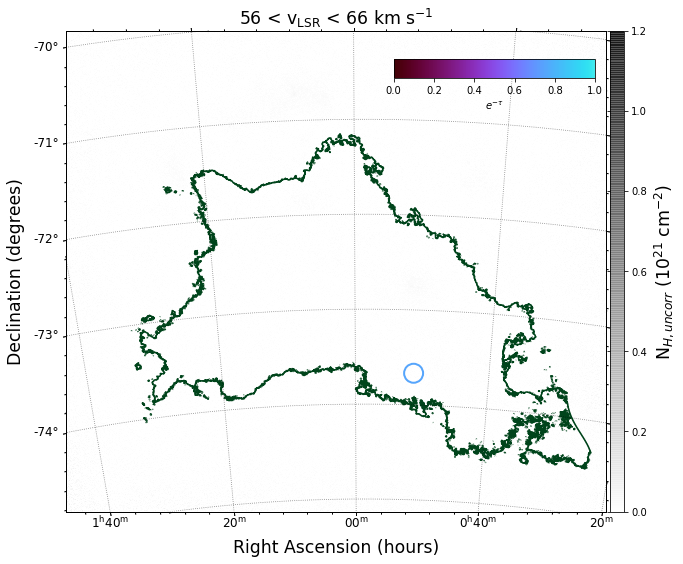

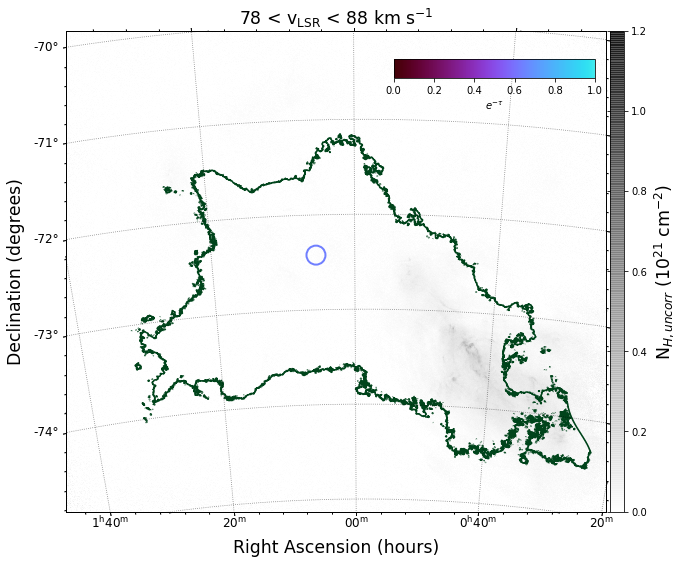

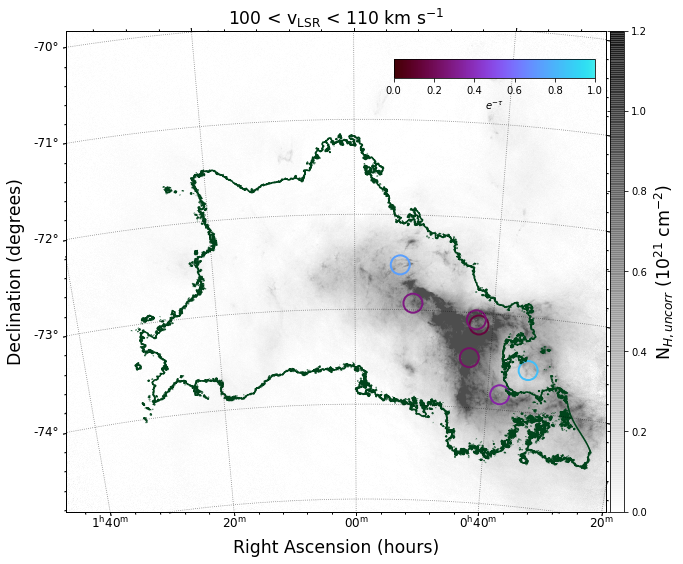

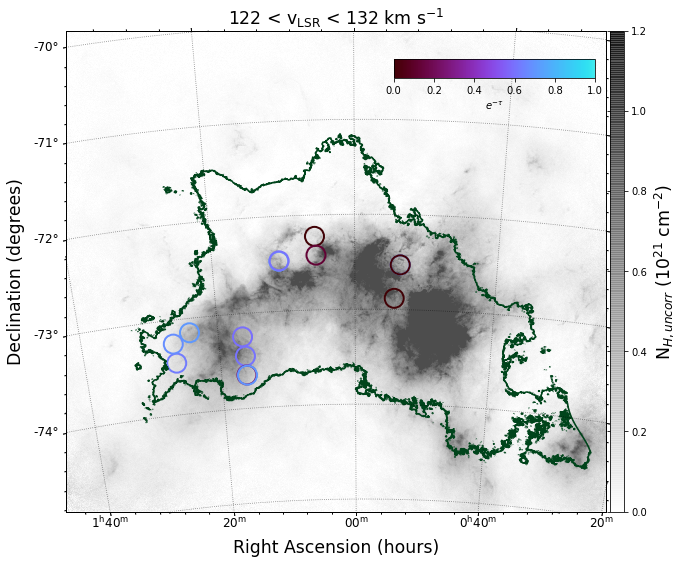

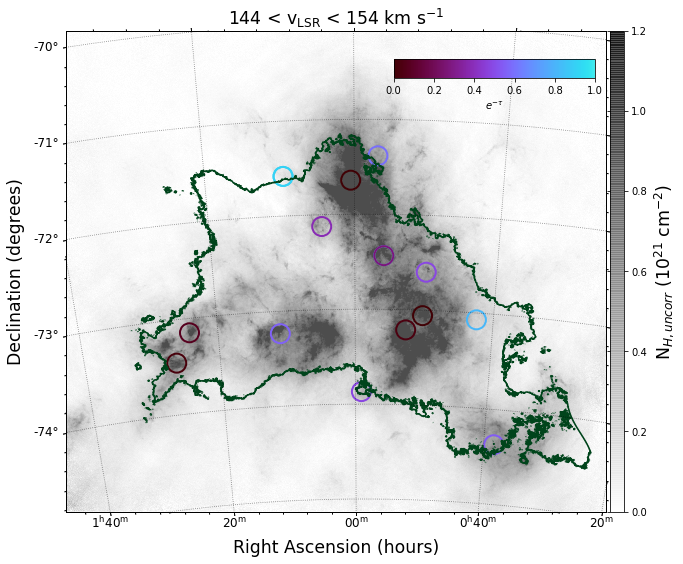

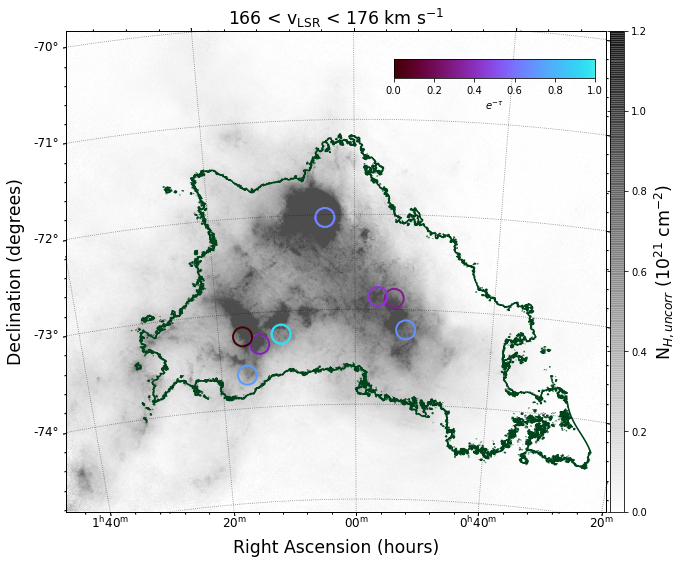

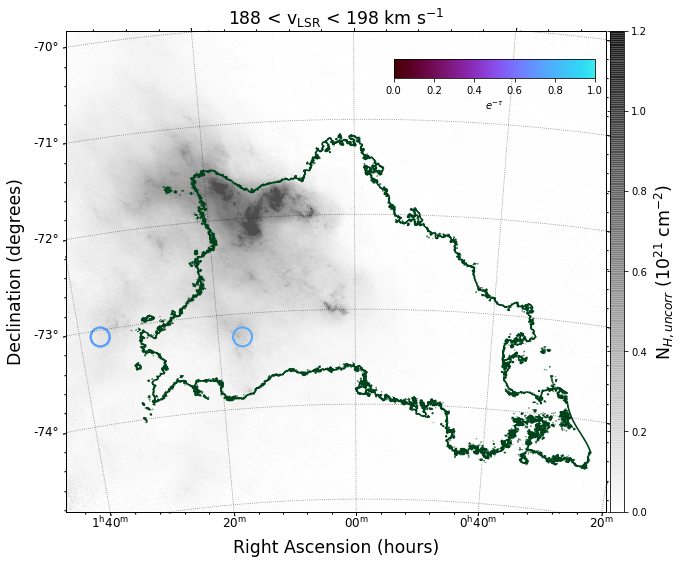

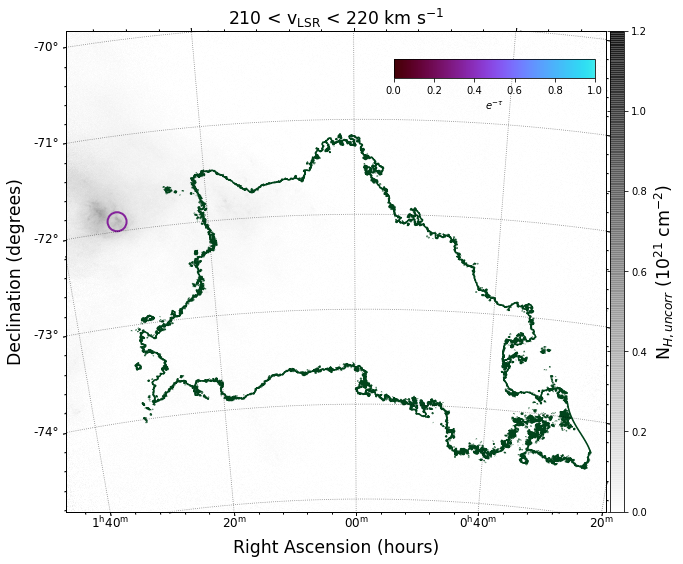

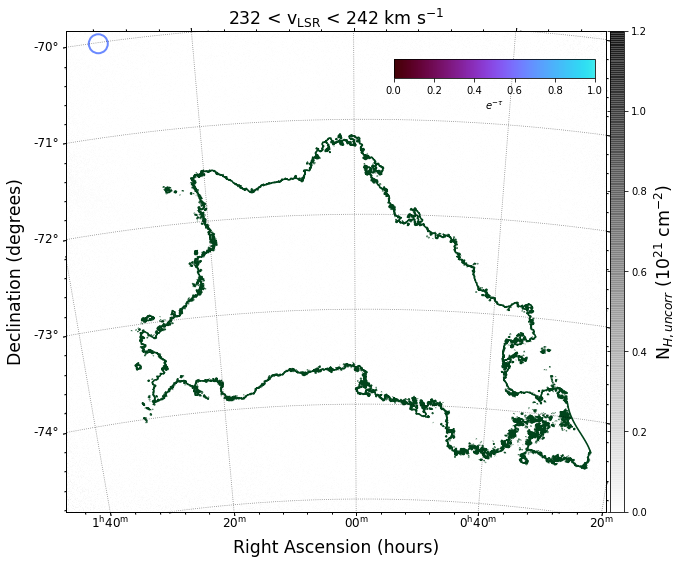

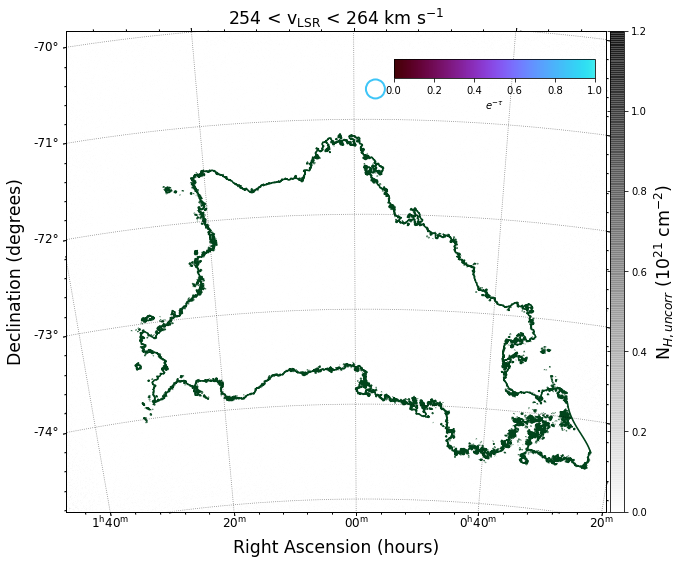

In [13]:
plt.rc('font', family='san-serif')

mid_vel = abs_table['start_vel'] + (abs_table['end_vel']-abs_table['start_vel'])/2

#cmap = plt.cm.gist_heat_r
cmap = cmr.gem
cnorm  = colors.Normalize(vmin=0, vmax=1)
scalar_map = plt.cm.ScalarMappable(norm=cnorm, cmap=cmap)

# For each slice
for idx, vel in enumerate(vel_start[::2]):
    #if vel > 70:
    #    break
    #if vel != 144. and vel != 156. and vel != 166.:
    #    continue

    # extract source list
    abs_subset = abs_table[(mid_vel >= vel) & (mid_vel < vel+11)]
    print ("Range {:.0f} to {:.0f} has {} features".format(vel, vel+10, len(abs_subset)))
    
    # Extract slab
    #print ("extracting slab...")
    #slab = vel_cube.spectral_slab(vel*u.km/u.s, (vel+10)*u.km/u.s)
    #print (slab.spectral_extrema)
    #mom0 = slab.moment0()
    #print (mom0)
    #mom0 =  (mom0 * 1.82 * 10**18 /1e3 ) / 1e21
    #mom0_fname = 'moment0.fits'
    #mom0.write(mom0_fname, overwrite=True)
    mom0_fname = 'data/moment0_vel{:.0f}.fits'.format(vel)

    # Plot map
    print ("plotting map...")
    title = r'{:.0f} < v$_{{\rm LSR}}$ < {:.0f} km s$^{{-1}}$'.format(vel, vel+10)
    
    #fig, ax = plt.subplots()
    #divider = make_axes_locatable(ax)
    #cax = divider.append_axes('bottom', size='5%', pad=0.05)
    #gc = aplpy.FITSFigure(mom0_fname, figure=fig)

    #wcs = WCS(fits.getheader(mom0_fname))
    #shape = wcs.array_shape
    #img_center = wcs.pixel_to_world(shape[0]//2, shape[1]//2)
    #print (img_center)
    
    gc = aplpy.FITSFigure(mom0_fname)#, figsize=(8, 6))
    # Show the inner 80%
    zoom_aply_fig(gc, 0.75)
    
    orig_x_lim = gc.ax.get_xlim()
    
    gc.show_grayscale(invert=True, vmin=0, vmax=1.2)
    gc.image.set_alpha(0.7)
    gc.add_colorbar()
    gc.colorbar.set_axis_label_text(r'N$_{H,uncorr}$ (10$^{21}$ cm$^{-2}$)')
    gc.colorbar.set_axis_label_font(size='xx-large')
    
    # PLot the outline of the SMC
    threshold = 2.0E21  / (1.82E18)
    mom0 = fits.open('SMC_askap_parkes_PBC_K_mom0.fits')
    mom0_data = mom0[0].data[0,]
    mom0_data[~spatial_mask] = 0
    gc.show_contour(mom0_data, levels=[threshold], overlap=True, cmap='Greens_r')

    #gc.show_contour('SMC_askap_parkes_PBC_pilot_K_mom0.fits', levels=[threshold], overlap=True, cmap='Greens_r')

    gc.add_grid()
    gc.grid.set_color('black')
    gc.grid.set_linestyle(':')
    gc.set_title(title, fontsize='xx-large')
    gc.axis_labels.set_xtext('Right Ascension (hours)')
    gc.axis_labels.set_ytext('Declination (degrees)')
    gc.axis_labels.set_font(size='xx-large')
    gc.tick_labels.set_font(size='large')

    # Overlay with absorption features
    color_val = scalar_map.to_rgba(abs_subset['min_optical_depth'])
    gc.show_circles(abs_subset['ra'], abs_subset['dec'], 0.1, edgecolor=color_val, lw=2)
    
    cax = plt.gcf().add_axes([0.58, 0.80, 0.28, 0.03])
    plt.colorbar(scalar_map, cax=cax, orientation='horizontal', label=r'$e^{-\tau}$')

    gc.savefig('movies/smc_gaskap_pilot_{:02d}.png'.format(idx))

    #break

### Two slices per plot

In [11]:
def extract_slab(vel_cube, vel):
    vel_int = "{:.0f}".format(vel)
    # Extract slab
    print ("extracting slab at vel {}...".format(vel_int))
    slab = vel_cube.spectral_slab(vel*u.km/u.s, (vel+10)*u.km/u.s)
    print (slab.spectral_extrema)
    mom0 = slab.moment0()
    mom0 =  (mom0 * 1.82 * 10**18 /1e3 ) / 1e21
    mom0_fname = 'data/moment0_vel{}.fits'.format(vel_int)
    mom0.write(mom0_fname, overwrite=True)



In [55]:
print (vel_start)
mid_vel = abs_table['start_vel'] + (abs_table['end_vel']-abs_table['start_vel'])/2
for vel in vel_start:
    extract_slab(vel_cube, vel)



[ 56.  67.  78.  89. 100. 111. 122. 133. 144. 155. 166. 177. 188. 199.
 210. 221. 232. 243. 254.]
extracting slab at vel 56...
(<Quantity 55567.33270647 m / s>, <Quantity 66316.51404412 m / s>)


/Users/jamesdempsey/anaconda/envs/python3/lib/python3.6/site-packages/spectral_cube/masks.py:219: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  sliced_data = np.memmap(ntf, mode='w+', shape=data[view].shape,
/Users/jamesdempsey/anaconda/envs/python3/lib/python3.6/site-packages/spectral_cube/masks.py:221: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  sliced_data[:] = data[view]
/Users/jamesdempsey/anaconda/envs/python3/lib/python3.6/site-packages/spectral_cube/masks.py:629: FutureWarning: Using a non-tuple sequence for multidimensional ind

extracting slab at vel 67...
(<Quantity 67293.71234754 m / s>, <Quantity 77065.69538177 m / s>)


/Users/jamesdempsey/anaconda/envs/python3/lib/python3.6/site-packages/spectral_cube/masks.py:219: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  sliced_data = np.memmap(ntf, mode='w+', shape=data[view].shape,
/Users/jamesdempsey/anaconda/envs/python3/lib/python3.6/site-packages/spectral_cube/masks.py:221: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  sliced_data[:] = data[view]
/Users/jamesdempsey/anaconda/envs/python3/lib/python3.6/site-packages/spectral_cube/masks.py:629: FutureWarning: Using a non-tuple sequence for multidimensional ind

extracting slab at vel 78...
(<Quantity 78042.8936852 m / s>, <Quantity 87814.87671943 m / s>)


/Users/jamesdempsey/anaconda/envs/python3/lib/python3.6/site-packages/spectral_cube/masks.py:219: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  sliced_data = np.memmap(ntf, mode='w+', shape=data[view].shape,
/Users/jamesdempsey/anaconda/envs/python3/lib/python3.6/site-packages/spectral_cube/masks.py:221: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  sliced_data[:] = data[view]
/Users/jamesdempsey/anaconda/envs/python3/lib/python3.6/site-packages/spectral_cube/masks.py:629: FutureWarning: Using a non-tuple sequence for multidimensional ind

extracting slab at vel 89...
(<Quantity 88792.07502285 m / s>, <Quantity 98564.05805708 m / s>)


/Users/jamesdempsey/anaconda/envs/python3/lib/python3.6/site-packages/spectral_cube/masks.py:219: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  sliced_data = np.memmap(ntf, mode='w+', shape=data[view].shape,
/Users/jamesdempsey/anaconda/envs/python3/lib/python3.6/site-packages/spectral_cube/masks.py:221: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  sliced_data[:] = data[view]
/Users/jamesdempsey/anaconda/envs/python3/lib/python3.6/site-packages/spectral_cube/masks.py:629: FutureWarning: Using a non-tuple sequence for multidimensional ind

extracting slab at vel 100...
(<Quantity 99541.2563605 m / s>, <Quantity 110290.43769815 m / s>)


/Users/jamesdempsey/anaconda/envs/python3/lib/python3.6/site-packages/spectral_cube/masks.py:219: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  sliced_data = np.memmap(ntf, mode='w+', shape=data[view].shape,
/Users/jamesdempsey/anaconda/envs/python3/lib/python3.6/site-packages/spectral_cube/masks.py:221: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  sliced_data[:] = data[view]
/Users/jamesdempsey/anaconda/envs/python3/lib/python3.6/site-packages/spectral_cube/masks.py:629: FutureWarning: Using a non-tuple sequence for multidimensional ind

extracting slab at vel 111...
(<Quantity 111267.63600158 m / s>, <Quantity 121039.61903581 m / s>)


/Users/jamesdempsey/anaconda/envs/python3/lib/python3.6/site-packages/spectral_cube/masks.py:219: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  sliced_data = np.memmap(ntf, mode='w+', shape=data[view].shape,
/Users/jamesdempsey/anaconda/envs/python3/lib/python3.6/site-packages/spectral_cube/masks.py:221: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  sliced_data[:] = data[view]
/Users/jamesdempsey/anaconda/envs/python3/lib/python3.6/site-packages/spectral_cube/masks.py:629: FutureWarning: Using a non-tuple sequence for multidimensional ind

extracting slab at vel 122...
(<Quantity 122016.81733923 m / s>, <Quantity 131788.80037346 m / s>)


/Users/jamesdempsey/anaconda/envs/python3/lib/python3.6/site-packages/spectral_cube/masks.py:219: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  sliced_data = np.memmap(ntf, mode='w+', shape=data[view].shape,
/Users/jamesdempsey/anaconda/envs/python3/lib/python3.6/site-packages/spectral_cube/masks.py:221: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  sliced_data[:] = data[view]
/Users/jamesdempsey/anaconda/envs/python3/lib/python3.6/site-packages/spectral_cube/masks.py:629: FutureWarning: Using a non-tuple sequence for multidimensional ind

extracting slab at vel 133...
(<Quantity 132765.99867688 m / s>, <Quantity 142537.98171111 m / s>)


/Users/jamesdempsey/anaconda/envs/python3/lib/python3.6/site-packages/spectral_cube/masks.py:219: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  sliced_data = np.memmap(ntf, mode='w+', shape=data[view].shape,
/Users/jamesdempsey/anaconda/envs/python3/lib/python3.6/site-packages/spectral_cube/masks.py:221: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  sliced_data[:] = data[view]
/Users/jamesdempsey/anaconda/envs/python3/lib/python3.6/site-packages/spectral_cube/masks.py:629: FutureWarning: Using a non-tuple sequence for multidimensional ind

extracting slab at vel 144...
(<Quantity 143515.18001454 m / s>, <Quantity 154264.36135219 m / s>)


/Users/jamesdempsey/anaconda/envs/python3/lib/python3.6/site-packages/spectral_cube/masks.py:219: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  sliced_data = np.memmap(ntf, mode='w+', shape=data[view].shape,
/Users/jamesdempsey/anaconda/envs/python3/lib/python3.6/site-packages/spectral_cube/masks.py:221: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  sliced_data[:] = data[view]
/Users/jamesdempsey/anaconda/envs/python3/lib/python3.6/site-packages/spectral_cube/masks.py:629: FutureWarning: Using a non-tuple sequence for multidimensional ind

extracting slab at vel 155...
(<Quantity 155241.55965561 m / s>, <Quantity 165013.54268984 m / s>)


/Users/jamesdempsey/anaconda/envs/python3/lib/python3.6/site-packages/spectral_cube/masks.py:219: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  sliced_data = np.memmap(ntf, mode='w+', shape=data[view].shape,
/Users/jamesdempsey/anaconda/envs/python3/lib/python3.6/site-packages/spectral_cube/masks.py:221: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  sliced_data[:] = data[view]
/Users/jamesdempsey/anaconda/envs/python3/lib/python3.6/site-packages/spectral_cube/masks.py:629: FutureWarning: Using a non-tuple sequence for multidimensional ind

extracting slab at vel 166...
(<Quantity 165990.74099327 m / s>, <Quantity 175762.7240275 m / s>)


/Users/jamesdempsey/anaconda/envs/python3/lib/python3.6/site-packages/spectral_cube/masks.py:219: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  sliced_data = np.memmap(ntf, mode='w+', shape=data[view].shape,
/Users/jamesdempsey/anaconda/envs/python3/lib/python3.6/site-packages/spectral_cube/masks.py:221: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  sliced_data[:] = data[view]
/Users/jamesdempsey/anaconda/envs/python3/lib/python3.6/site-packages/spectral_cube/masks.py:629: FutureWarning: Using a non-tuple sequence for multidimensional ind

extracting slab at vel 177...
(<Quantity 176739.92233092 m / s>, <Quantity 186511.90536515 m / s>)


/Users/jamesdempsey/anaconda/envs/python3/lib/python3.6/site-packages/spectral_cube/masks.py:219: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  sliced_data = np.memmap(ntf, mode='w+', shape=data[view].shape,
/Users/jamesdempsey/anaconda/envs/python3/lib/python3.6/site-packages/spectral_cube/masks.py:221: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  sliced_data[:] = data[view]
/Users/jamesdempsey/anaconda/envs/python3/lib/python3.6/site-packages/spectral_cube/masks.py:629: FutureWarning: Using a non-tuple sequence for multidimensional ind

extracting slab at vel 188...
(<Quantity 188466.30197199 m / s>, <Quantity 198238.28500622 m / s>)


/Users/jamesdempsey/anaconda/envs/python3/lib/python3.6/site-packages/spectral_cube/masks.py:219: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  sliced_data = np.memmap(ntf, mode='w+', shape=data[view].shape,
/Users/jamesdempsey/anaconda/envs/python3/lib/python3.6/site-packages/spectral_cube/masks.py:221: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  sliced_data[:] = data[view]
/Users/jamesdempsey/anaconda/envs/python3/lib/python3.6/site-packages/spectral_cube/masks.py:629: FutureWarning: Using a non-tuple sequence for multidimensional ind

extracting slab at vel 199...
(<Quantity 199215.48330965 m / s>, <Quantity 208987.46634388 m / s>)


/Users/jamesdempsey/anaconda/envs/python3/lib/python3.6/site-packages/spectral_cube/masks.py:219: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  sliced_data = np.memmap(ntf, mode='w+', shape=data[view].shape,
/Users/jamesdempsey/anaconda/envs/python3/lib/python3.6/site-packages/spectral_cube/masks.py:221: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  sliced_data[:] = data[view]
/Users/jamesdempsey/anaconda/envs/python3/lib/python3.6/site-packages/spectral_cube/masks.py:629: FutureWarning: Using a non-tuple sequence for multidimensional ind

extracting slab at vel 210...
(<Quantity 209964.6646473 m / s>, <Quantity 219736.64768153 m / s>)


/Users/jamesdempsey/anaconda/envs/python3/lib/python3.6/site-packages/spectral_cube/masks.py:219: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  sliced_data = np.memmap(ntf, mode='w+', shape=data[view].shape,
/Users/jamesdempsey/anaconda/envs/python3/lib/python3.6/site-packages/spectral_cube/masks.py:221: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  sliced_data[:] = data[view]
/Users/jamesdempsey/anaconda/envs/python3/lib/python3.6/site-packages/spectral_cube/masks.py:629: FutureWarning: Using a non-tuple sequence for multidimensional ind

extracting slab at vel 221...
(<Quantity 220713.84598495 m / s>, <Quantity 231463.02732261 m / s>)


/Users/jamesdempsey/anaconda/envs/python3/lib/python3.6/site-packages/spectral_cube/masks.py:219: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  sliced_data = np.memmap(ntf, mode='w+', shape=data[view].shape,
/Users/jamesdempsey/anaconda/envs/python3/lib/python3.6/site-packages/spectral_cube/masks.py:221: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  sliced_data[:] = data[view]
/Users/jamesdempsey/anaconda/envs/python3/lib/python3.6/site-packages/spectral_cube/masks.py:629: FutureWarning: Using a non-tuple sequence for multidimensional ind

extracting slab at vel 232...
(<Quantity 232440.22562603 m / s>, <Quantity 242212.20866026 m / s>)


/Users/jamesdempsey/anaconda/envs/python3/lib/python3.6/site-packages/spectral_cube/masks.py:219: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  sliced_data = np.memmap(ntf, mode='w+', shape=data[view].shape,
/Users/jamesdempsey/anaconda/envs/python3/lib/python3.6/site-packages/spectral_cube/masks.py:221: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  sliced_data[:] = data[view]
/Users/jamesdempsey/anaconda/envs/python3/lib/python3.6/site-packages/spectral_cube/masks.py:629: FutureWarning: Using a non-tuple sequence for multidimensional ind

extracting slab at vel 243...
(<Quantity 243189.40696368 m / s>, <Quantity 252961.38999791 m / s>)


/Users/jamesdempsey/anaconda/envs/python3/lib/python3.6/site-packages/spectral_cube/masks.py:219: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  sliced_data = np.memmap(ntf, mode='w+', shape=data[view].shape,
/Users/jamesdempsey/anaconda/envs/python3/lib/python3.6/site-packages/spectral_cube/masks.py:221: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  sliced_data[:] = data[view]
/Users/jamesdempsey/anaconda/envs/python3/lib/python3.6/site-packages/spectral_cube/masks.py:629: FutureWarning: Using a non-tuple sequence for multidimensional ind

extracting slab at vel 254...
(<Quantity 253938.58830134 m / s>, <Quantity 257847.38151503 m / s>)


In [56]:
# Contours

In [17]:
def plot_slab(vel_cube, vel, fig, pos, abs_subset, slice_num):    
    mom0_fname = 'data/moment0_vel{:.0f}.fits'.format(vel)
    
    alpha = 'abcdefghijklmnopqrstuvwxyz'
    # Plot map
    title = r'({:s}) {:.0f} < v$_{{\rm LSR}}$ < {:.0f} km s$^{{-1}}$'.format(alpha[slice_num-1], vel, vel+10)
    print ("plotting map for {}...".format(title))

    if pos == 1:
        subplot=[0.1,0.12,0.34,0.76]
    else:
        subplot=[0.49,0.1,0.36,0.8]
    gc = aplpy.FITSFigure(mom0_fname, figure=fig, subplot=subplot)
    zoom_aply_fig(gc, 0.75)

    gc.show_grayscale(invert=True, vmin=0, vmax=1.2)
    gc.image.set_alpha(0.7)

    if pos == 2:
        gc.add_colorbar()
        gc.colorbar.set_axis_label_text(r'N$_{H,uncorr}$ (10$^{21}$ cm$^{-2}$)')
        gc.colorbar.set_axis_label_font(size='xx-large')
        gc.axis_labels.hide_y()
        
    # PLot the outline of the SMC
    #threshold = 2.0E21 * 1.0E3 / (1.82E18)
    #gc.show_contour('SMC_askap_parkes_PBC_pilot_K_mom0.fits', levels=[threshold], overlap=True, cmap='Greens_r')
    # PLot the outline of the SMC
    threshold = 2.0E21  / (1.82E18)
    mom0 = fits.open('SMC_askap_parkes_PBC_K_mom0.fits')
    mom0_data = mom0[0].data[0,]
    mom0_data[~spatial_mask] = 0
    gc.show_contour(mom0_data, levels=[threshold], overlap=True, cmap='Greens_r')

    gc.add_grid()
    gc.grid.set_color('black')
    gc.grid.set_linestyle(':')
    gc.set_title(title,size='xx-large')
    gc.axis_labels.set_xtext('Right Ascension (hours)')
    gc.axis_labels.set_ytext('Declination (degrees)')
    gc.axis_labels.set_font(size='xx-large')
    gc.tick_labels.set_font(size='large')


    # Overlay with absorption features
    color_val = scalar_map.to_rgba(abs_subset['min_optical_depth'])
    #print(abs_subset['min_opacity'])
    #gc.show_circles(abs_subset['ra'], abs_subset['dec'], 0.125, edgecolor='white', lw=1)
    gc.show_circles(abs_subset['ra'], abs_subset['dec'], 0.1, edgecolor=color_val, lw=2)
    
    xpos = 0.33 if pos == 1 else 0.72
    cax = plt.gcf().add_axes([xpos, 0.80, 0.10, 0.03], zorder=2)
    plt.colorbar(scalar_map, cax=cax, orientation='horizontal', label=r'$e^{-\tau}$')


Range 56 to 66 has 1 features
plotting map for (a) 56 < v$_{\rm LSR}$ < 66 km s$^{-1}$...


Range 67 to 77 has 0 features
plotting map for (b) 67 < v$_{\rm LSR}$ < 77 km s$^{-1}$...


Range 78 to 88 has 1 features
plotting map for (c) 78 < v$_{\rm LSR}$ < 88 km s$^{-1}$...


Range 89 to 99 has 1 features
plotting map for (d) 89 < v$_{\rm LSR}$ < 99 km s$^{-1}$...


Range 100 to 110 has 7 features
plotting map for (e) 100 < v$_{\rm LSR}$ < 110 km s$^{-1}$...


Range 111 to 121 has 14 features
plotting map for (f) 111 < v$_{\rm LSR}$ < 121 km s$^{-1}$...


Range 122 to 132 has 14 features
plotting map for (g) 122 < v$_{\rm LSR}$ < 132 km s$^{-1}$...


Range 133 to 143 has 10 features
plotting map for (h) 133 < v$_{\rm LSR}$ < 143 km s$^{-1}$...


Range 144 to 154 has 16 features
plotting map for (i) 144 < v$_{\rm LSR}$ < 154 km s$^{-1}$...


Range 155 to 165 has 26 features
plotting map for (j) 155 < v$_{\rm LSR}$ < 165 km s$^{-1}$...


Range 166 to 176 has 12 features
plotting map for (k) 166 < v$_{\rm LSR}$ < 176 km s$^{-1}$...


Range 177 to 187 has 11 features
plotting map for (l) 177 < v$_{\rm LSR}$ < 187 km s$^{-1}$...


Range 188 to 198 has 3 features
plotting map for (m) 188 < v$_{\rm LSR}$ < 198 km s$^{-1}$...


Range 199 to 209 has 0 features
plotting map for (n) 199 < v$_{\rm LSR}$ < 209 km s$^{-1}$...


Range 210 to 220 has 1 features
plotting map for (o) 210 < v$_{\rm LSR}$ < 220 km s$^{-1}$...


Range 221 to 231 has 0 features
plotting map for (p) 221 < v$_{\rm LSR}$ < 231 km s$^{-1}$...


Range 232 to 242 has 1 features
plotting map for (q) 232 < v$_{\rm LSR}$ < 242 km s$^{-1}$...


Range 243 to 253 has 0 features
plotting map for (r) 243 < v$_{\rm LSR}$ < 253 km s$^{-1}$...


Range 254 to 264 has 1 features
plotting map for (s) 254 < v$_{\rm LSR}$ < 264 km s$^{-1}$...


IndexError: index 19 is out of bounds for axis 0 with size 19

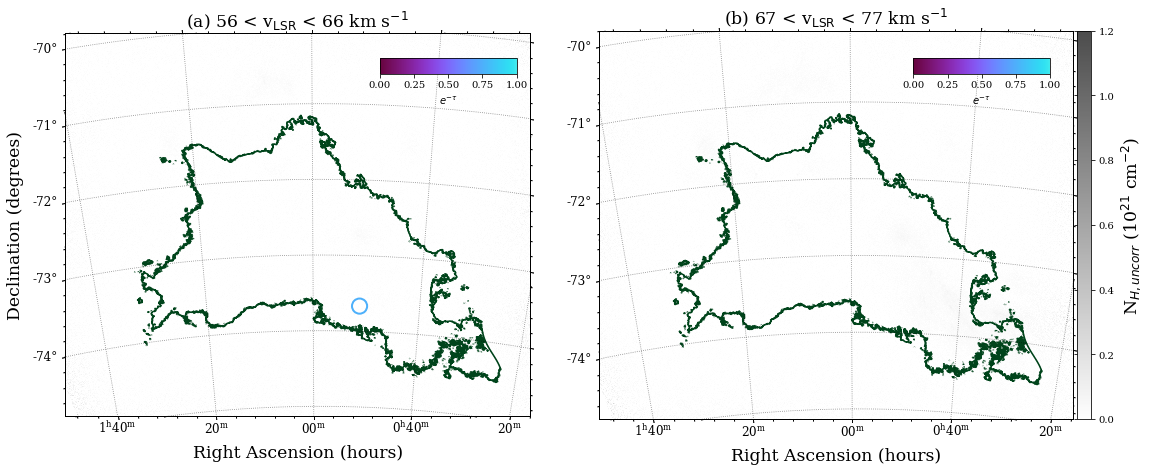

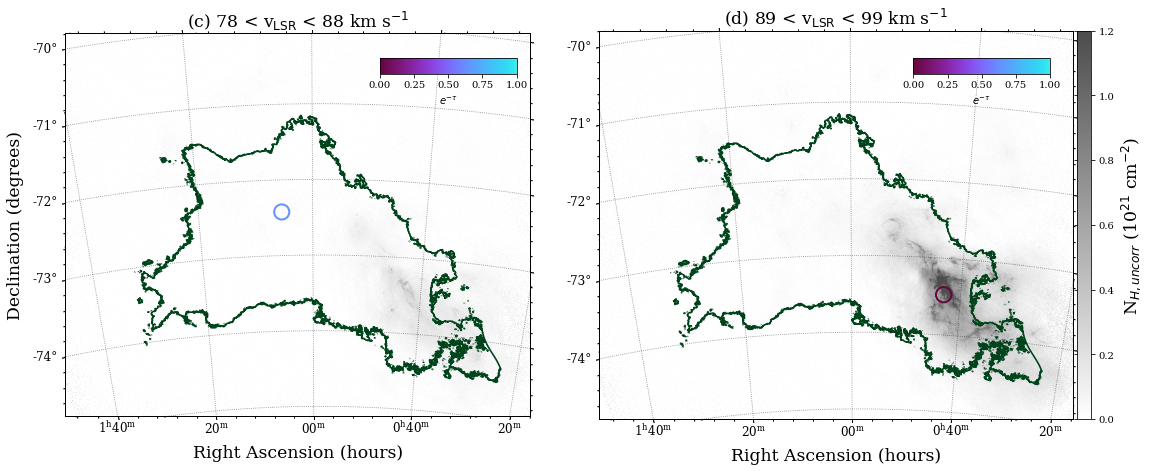

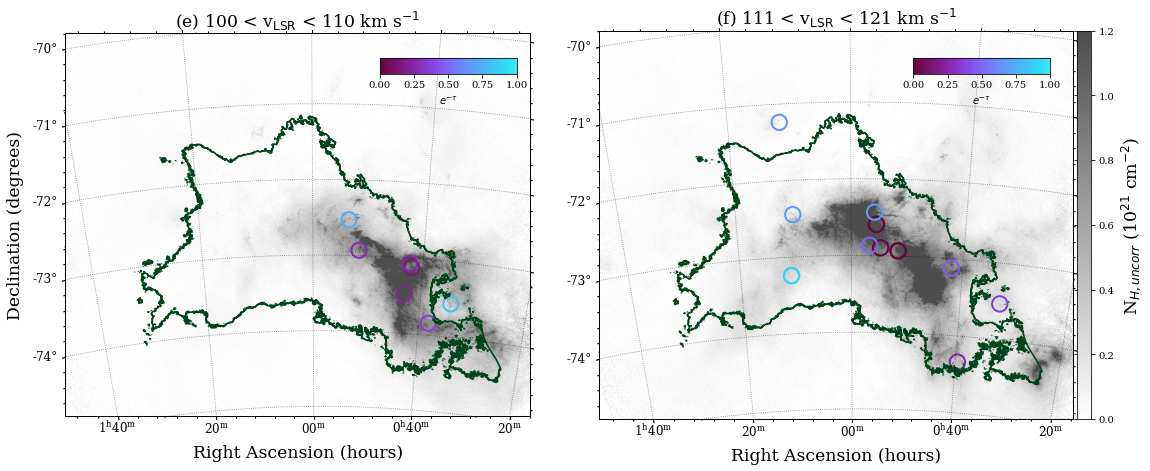

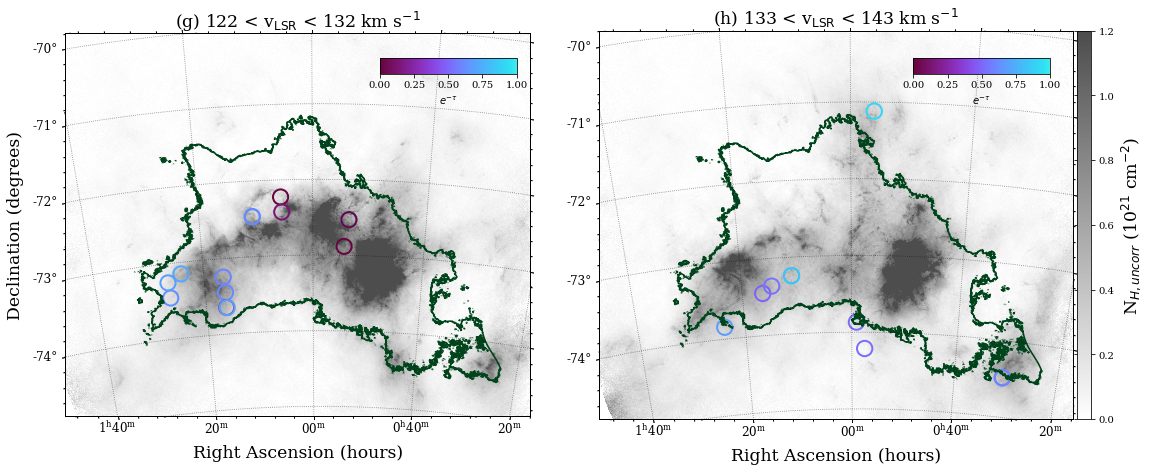

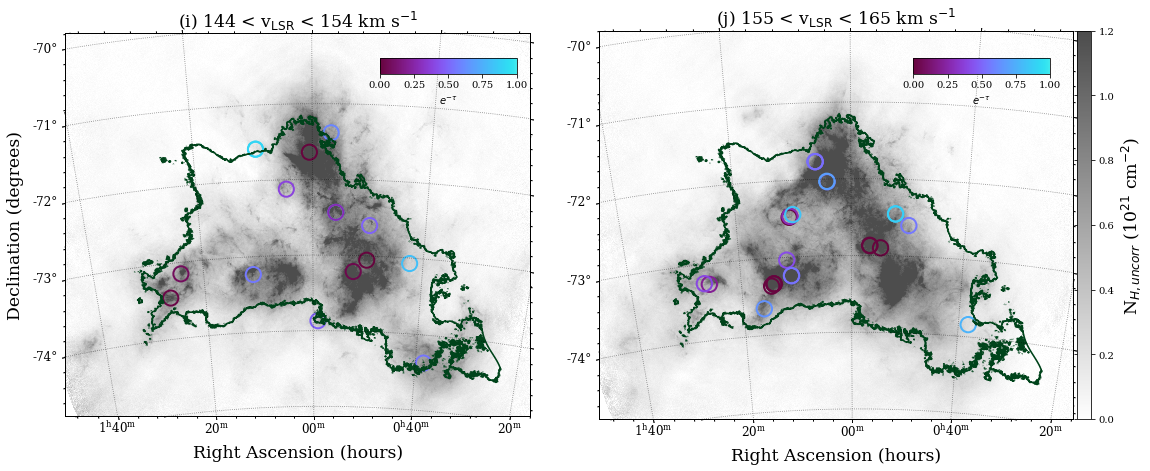

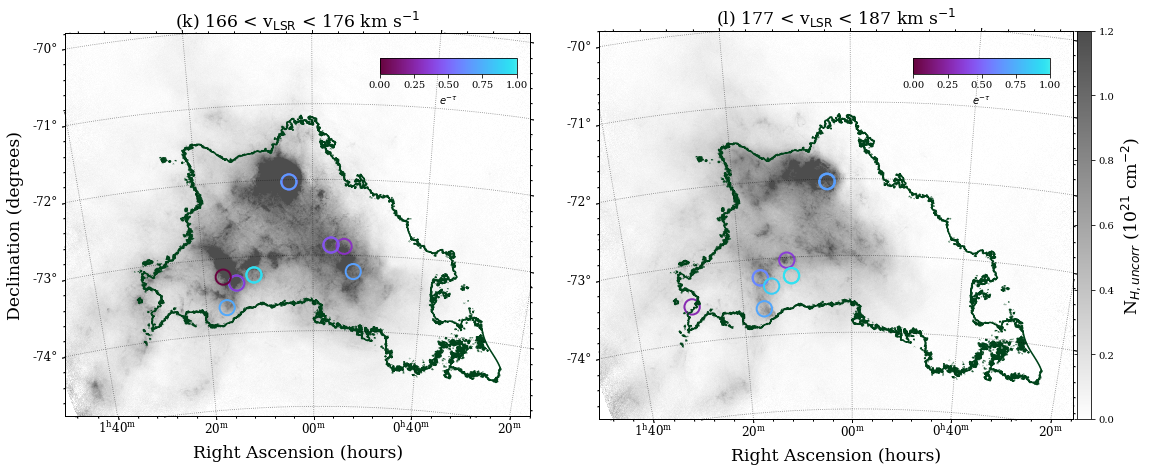

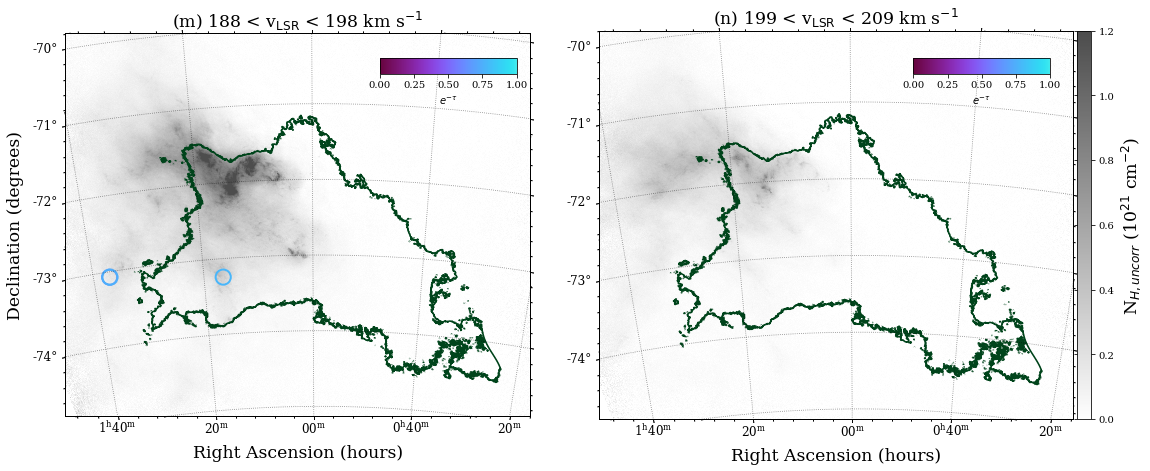

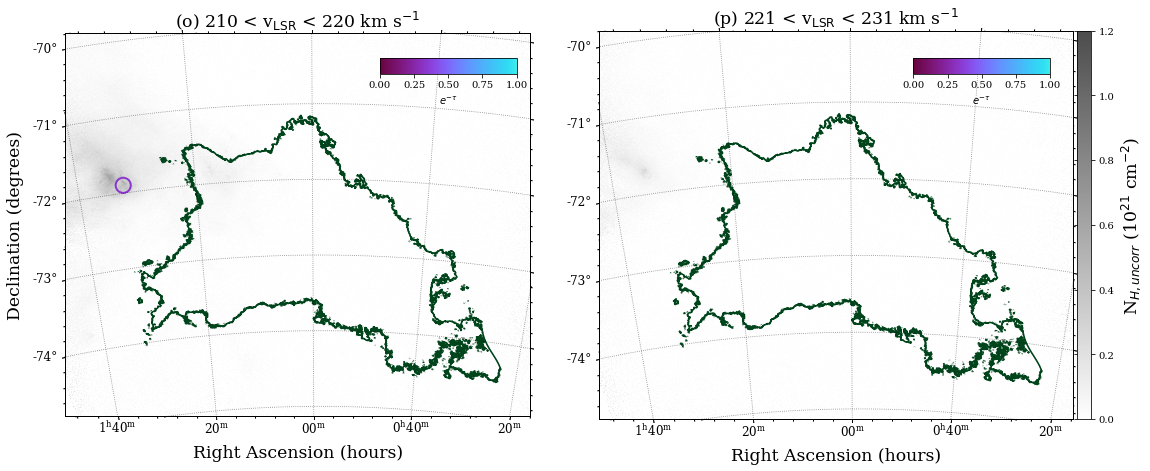

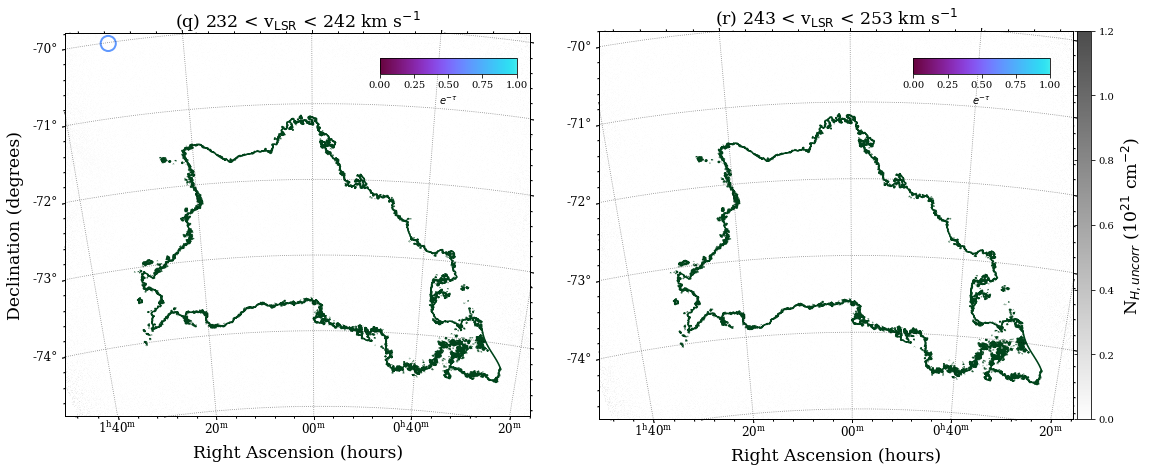

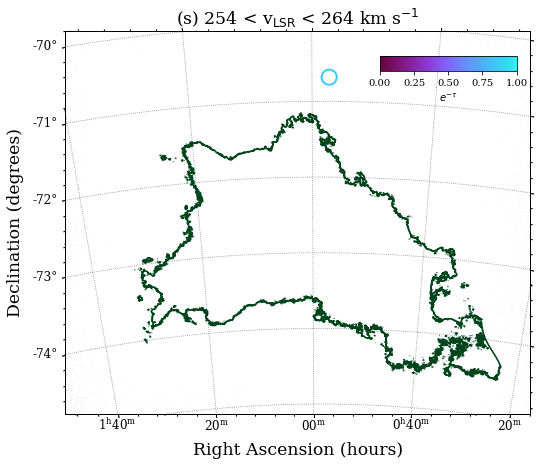

In [18]:
plt.rc('font', family='serif')

mid_vel = abs_table['start_vel'] + (abs_table['end_vel']-abs_table['start_vel'])/2

#cmap = plt.cm.gist_heat_r
cmap = cmr.get_sub_cmap('cmr.gem', 0.15, 1.0)
#new_cmap = mcolors.LinearSegmentedColormap.from_list(
#         'trunc({name},{a:.2f},{b:.2f})'.format(name=cmap.name, a=0.15, b=1.0),
#         cmap(np.linspace(0.15, 1.0, cmap.N)))
cnorm  = colors.Normalize(vmin=0, vmax=1)
scalar_map = plt.cm.ScalarMappable(norm=cnorm, cmap=cmap)

# For each slice
for idx, vel in enumerate(vel_start[::2]):
    #if vel > 120:
    #    break
    #if vel != 232. and vel != 100.:
    #    continue

    fig = plt.figure(figsize=(19, 7))

    for pos in [1,2]:
        slice_num = idx*2+pos
        slice_start_vel = vel_start[slice_num-1]
        # extract source list
        abs_subset = abs_table[(mid_vel >= slice_start_vel) & (mid_vel < slice_start_vel+11)]
        print ("Range {:.0f} to {:.0f} has {} features".format(slice_start_vel, slice_start_vel+10, len(abs_subset)))

        plot_slab(vel_cube, slice_start_vel, fig, pos, abs_subset, slice_num)

    fig.savefig('figures/smc_gaskap_pilot_slice_{:02d}.pdf'.format(idx), bbox_inches='tight')
    #break


### Histogram

<MaskedColumn name='start_vel' dtype='float64' length=16>
   98.21563634160628
   87.91882776065044
  14.847926565926567
   65.70290042854154
  10.239789203993524
  -1.308144131649431
   4.191855868209226
  0.4555939532244956
  0.4602006735120231
   1.008763965754959
    98.2388993138605
  0.5886135751040127
-0.20002982417511528
  0.9221119237245147
  45.277646173528495
 -1.1148688260370108

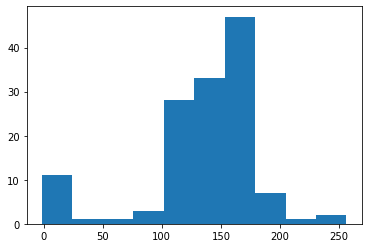

In [89]:
plt.hist(mid_vel)
mid_vel[mid_vel<100]

In [40]:
def plot_background_map(fig, background):

    # moment zero map
    mom0 = fits.open(background)

    no_nan_data = np.nan_to_num(mom0[0].data)
    nh_data = no_nan_data * 1.82 * 10**18 /1e3
    vmin=np.percentile(nh_data, 10)
    vmax=np.percentile(nh_data, 99.75)

    # Create an ImageNormalize object
    vmid = vmin - (vmax - vmin) / 30.
    asinh_a = (vmid - vmin) / (vmax - vmin)
    norm_kwargs = {'asinh_a': abs(asinh_a)}
    norm = simple_norm(nh_data, 'asinh', min_cut=vmin, max_cut=vmax, clip=False,
                                    **norm_kwargs)

    wcs = WCS(mom0[0].header)
    ax = fig.add_subplot(111, projection=wcs)
    im = ax.imshow(nh_data, cmap='gist_yarg', vmin=vmin, vmax=vmax, alpha=0.6, norm=norm)
    ax.grid()
    return ax, wcs


### scratch space

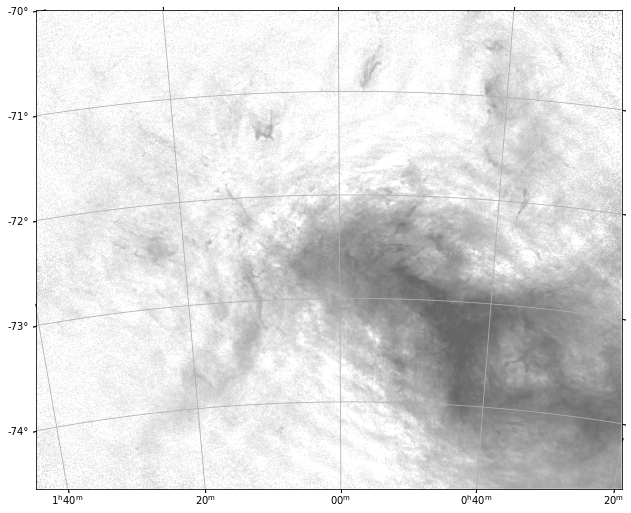

In [41]:
fig = plt.figure(figsize=(10.5, 9))
ax, wcs = plot_background_map(fig, 'moment0.fits')

In [48]:
abs_table

<Table masked=True length=134>
  id    comp_name    ...     min_opacity          max_sigma     
                     ...                                        
int64     str32      ...       float64             float64      
----- -------------- ... -------------------- ------------------
   13 J005535-723533 ... -0.33269286155700684   5.30127913221415
   13 J005535-723533 ... -0.06738349795341492 3.9506069933546564
   19 J005448-725353 ... -0.12201661616563797 3.6103350330925146
   19 J005448-725353 ...  -0.4760337173938751  4.795641731815016
   26 J010532-721331 ... -0.03233879804611206 4.2136830499302675
   33 J005014-730326 ... -0.06129693612456322 3.3129509665138017
   42 J013134-700042 ...   0.6641514301300049 3.1094194409255347
   60 J012924-733153 ...   0.2738746702671051  3.032484954960196
   65 J010556-714607 ...   0.5464287996292114   3.16242149403755
  ...            ... ...                  ...                ...
  368 J011050-731426 ...   0.9593512415885925  4.768086772953936
  369 J011056-731407 ...   0.5591721534729004 14.155633283210676
  370 J011049-731428 ...   0.9807697534561157 3.0350115225907377
  370 J011049-731428 ...   0.9034658670425415 13.473597672753355
  370 J011049-731428 ...   0.8315915465354919 20.415631662537596
  370 J011049-731428 ...    0.540591299533844 45.997348090023024
  370 J011049-731428 ...   0.9491565823554993  5.433862421248864
  370 J011049-731428 ...   0.9588507413864136  4.776405638490696
  373 J005611-710707 ...   0.9108920097351074 12.652462927415552
  373 J005611-710707 ...   0.9158968329429626 10.664882072776509

In [51]:
np.array(abs_subset['ra'])

array([12.9231  , 10.776987, 10.503238,  8.558827,  8.176282, 10.608736,
       13.406718,  7.278655,  9.537557])

INFO: Auto-setting vmin to -1.922e+21 [aplpy.core]
INFO: Auto-setting vmax to  1.710e+22 [aplpy.core]


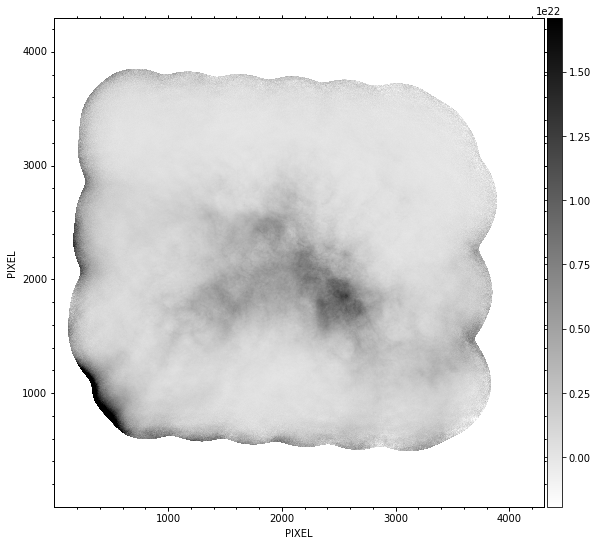

In [69]:
smc_mom0 = fits.open('../SMC_askap_parkes_PBC_pilot_K_mom0.fits')
smc_nh = smc_mom0[0].data * 1.82 * 10**18 /1e3
gc = aplpy.FITSFigure(smc_nh, smc_mom0[0].header)
gc.show_grayscale(invert=True) #, vmin=0, vmax=1.2, )
gc.add_colorbar()
outline_hdu = fits.
gc.show_contour(smc_nh, smc_mom0[0].header, )




In [13]:
cmap = plt.cm.gist_heat_r #colors.Colormap('gist_heat_r')
cnorm  = colors.Normalize(vmin=0, vmax=1)
scalar_map = plt.cm.ScalarMappable(norm=cnorm, cmap=cmap)
color_val = scalar_map.to_rgba(abs_subset['min_opacity'])




    min_opacity    
-------------------
 0.2884162664413452
 0.2352394163608551
0.14954429864883423
 0.8379071950912476
0.25672629475593567
 0.7334729433059692
0.23036128282546997
0.35714367032051086


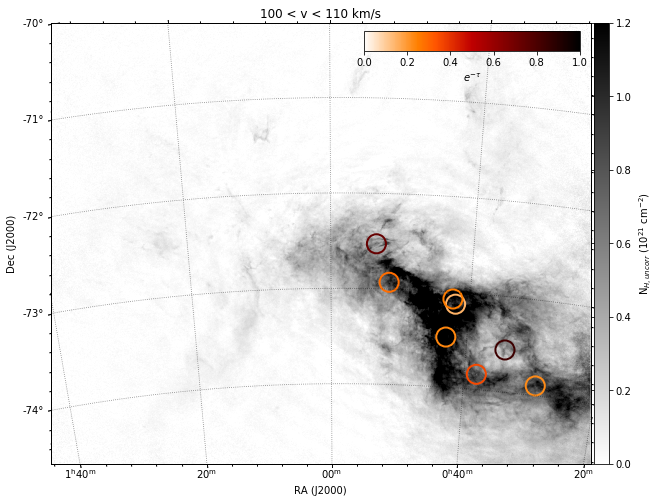

In [17]:
    gc = aplpy.FITSFigure(mom0_fname)
    gc.show_grayscale(invert=True, vmin=0, vmax=1.2)
    gc.add_colorbar()
    gc.colorbar.set_axis_label_text(r'N$_{H,uncorr}$ (10$^{21}$ cm$^{-2}$)')
    gc.add_grid()
    gc.grid.set_color('black')
    gc.grid.set_linestyle(':')
    gc.set_title(title)

    # Overlay with absorption features
    color_val = scalar_map.to_rgba(abs_subset['min_opacity'])
    print(abs_subset['min_opacity'])
    gc.show_circles(abs_subset['ra'], abs_subset['dec'], 0.1, edgecolor=color_val, lw=2)
    
    cax = plt.gcf().add_axes([0.56, 0.80, 0.3, 0.03])
    plt.colorbar(scalar_map, cax=cax, orientation='horizontal', label=r'$e^{-\tau}$')
    
    #for src in abs_subset:
    #    ax.scatter([src['ra']], [src['dec']], transform=ax.get_transform('world'), 
    #           marker='o', edgecolor='orange', facecolor='none')

    gc.savefig('figures/smc_gaskap_pilot_{:.0f}.png'.format(vel))

